In [6]:
from pystats_utils.utils.patient import Patient

import pandas as pd

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Mortality_31d"] == "no"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))

keys = ["Days", "Changes", "Atbs"]
times = ["Total", "Pre", "Post"]
groups = {"Amikacin"    : "Aminoglicosidos",
          "Gentamicin"  : "Aminoglicosidos",
          "Tigecycline" : "Tigecycline",
          "Colistin"    : "Polimixinas",
          "Polymyxin"   : "Polimixinas",
          "Caz-avi"     : "Caz-avi"}

result = {key : {time : {group : [] for group in groups.values()} for time in times} for key in keys}

for patient in patients:

    allAtbs = [element for step in patient.translateTreatmentLine(only = "active",
                                                                condensed = True,
                                                                start = patient.bloodculture,
                                                                days = False) for element in step if element != "None"]

    for atb in groups:
        if atb in allAtbs:

            # Days
            dayTreatment = patient.translateTreatmentLine(only = "active",
                                                          condensed = False,
                                                          start = patient.bloodculture,
                                                          days = False)
            for index, day in enumerate(dayTreatment):

                if atb in day:
                    result["Days"]["Total"][groups[atb]].append(len(dayTreatment))
                    result["Days"]["Pre"][groups[atb]].append(index)
                    result["Days"]["Post"][groups[atb]].append(len(dayTreatment) - index - 1)
                    break

            # Changes
            changeTreatment = patient.translateTreatmentLine(mergeInactive = True,
                                                             condensed = True,
                                                             start = patient.bloodculture,
                                                             days = False)
            for index, step in enumerate(changeTreatment):

                if atb in step:
                    result["Changes"]["Total"][groups[atb]].append(len(changeTreatment))
                    result["Changes"]["Pre"][groups[atb]].append(index)
                    result["Changes"]["Post"][groups[atb]].append(len(changeTreatment) - index - 1)
                    break

            # Changes
            atbsTreatment = patient.translateTreatmentLine(condensed = True,
                                                           mergeInactive = False,
                                                           start = patient.bloodculture,
                                                           days = False)
            for index, step in enumerate(atbsTreatment):
                if f"{atb}_S" in step:

                    allAtbs = set([element for step in atbsTreatment for element in step if element != "None"])

                    result["Atbs"]["Total"][groups[atb]].append(len(allAtbs) - 1)

                    preAtbs = set([element for step in atbsTreatment[:index] for element in step if element != "None"])
                    if f"{atb}_s" in preAtbs: preAtbs.remove(f"{atb}_s")

                    result["Atbs"]["Pre"][groups[atb]].append(len(preAtbs))

                    posAtbs = set([element for step in atbsTreatment[index + 1:] for element in step if element != "None"])
                    if f"{atb}_s" in posAtbs: posAtbs.remove(f"{atb}_s")

                    result["Atbs"]["Post"][groups[atb]].append(len(posAtbs))
                    break

import pandas as pd

template = {}

flag = True

for key, value in result.items():
    for time, value in value.items():
        aux = []

        names = []

        for group, values in value.items():
            aux += values
            names += [group] * len(values)

        if flag:
            template["group"] = names

        template[f"{key}_{time}"] = aux

data = pd.DataFrame(template)
data.to_excel("test.xlsx")

In [2]:
set(data["group"])

{'Aminoglicosidos', 'Caz-avi', 'Polimixinas', 'Tigecycline'}

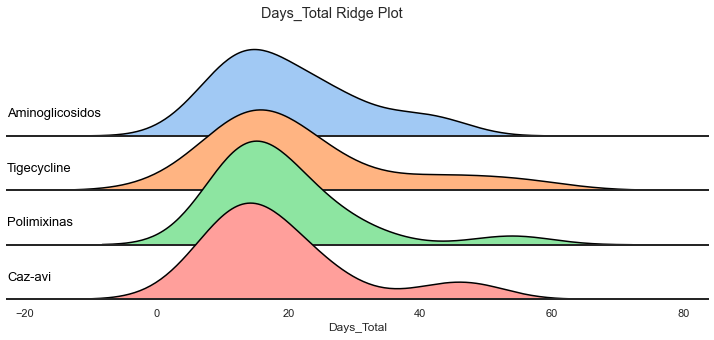

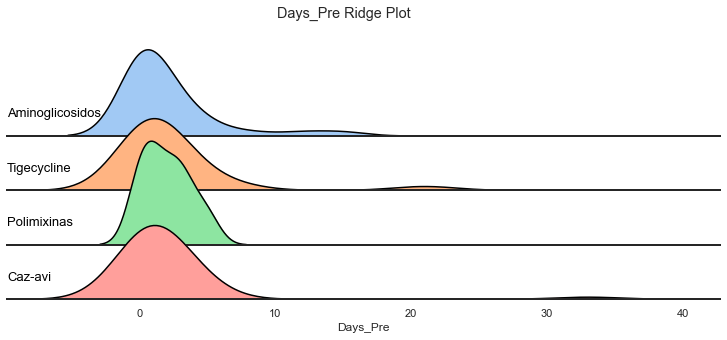

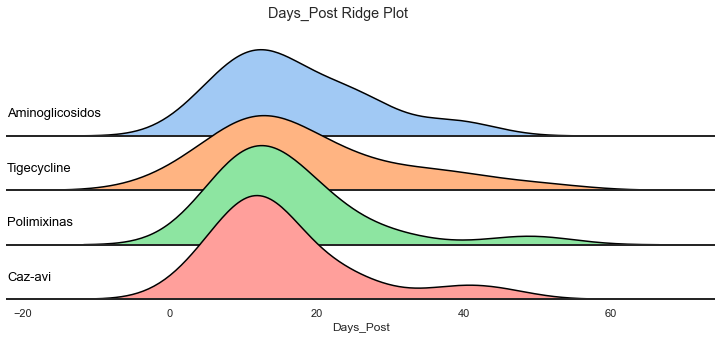

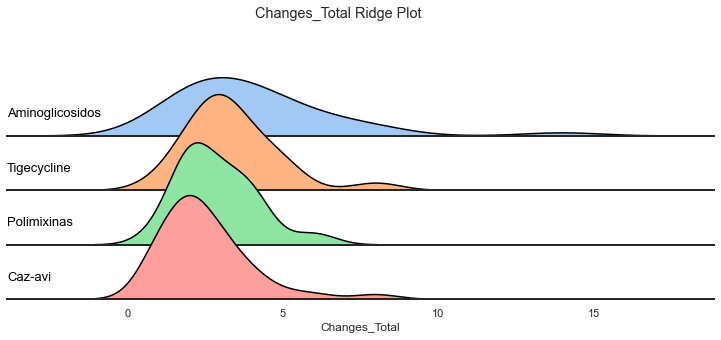

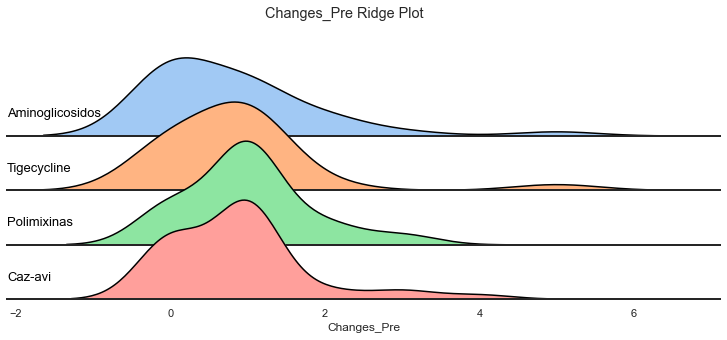

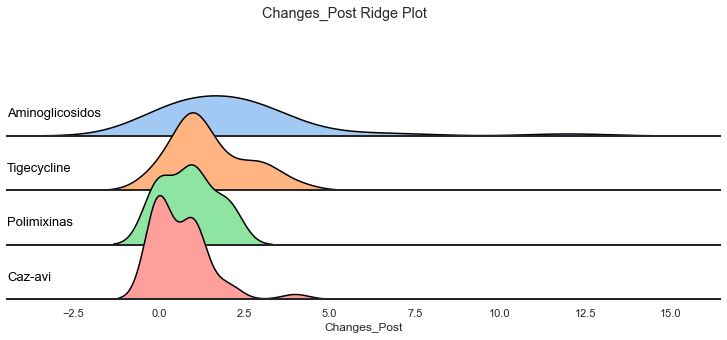

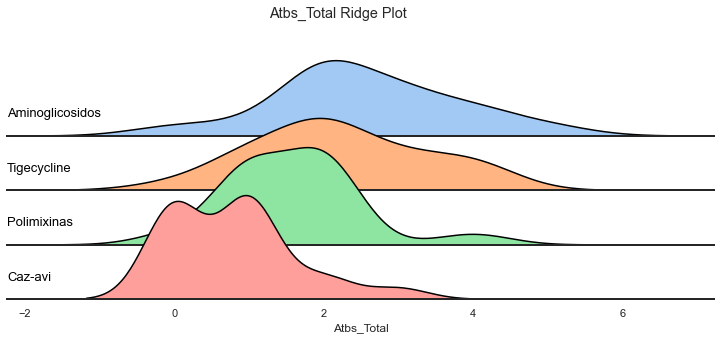

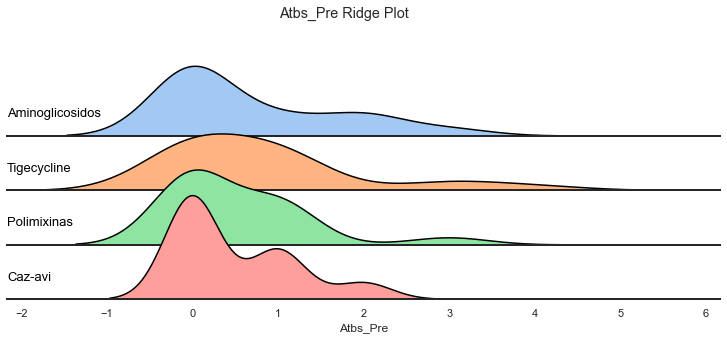

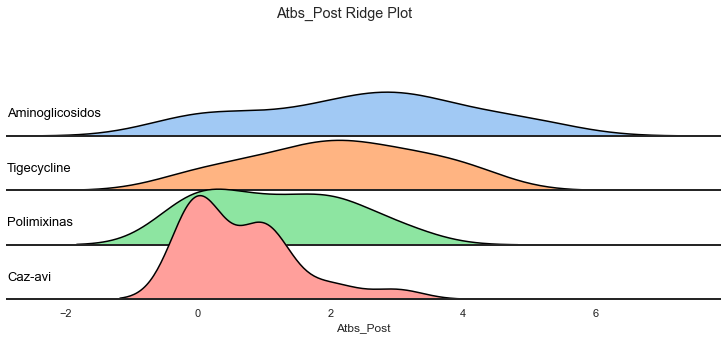

In [7]:
import pandas as pd
import numpy as np

from pystats_utils.plot import RidgePlot
from pystats_utils.test.value_comparison import MannWhitneyUTest

template = {"Variable"        : [],
            "All"             : [],
            "Aminoglicosidos" : [],
            "Polimixinas"     : [],
            "Tigecycline"     : [],
            "Caz-avi"         : [],
            "Caz-avi vs. Aminoglicosidos" : [],
            "Caz-avi vs. Polimixinas"     : [],
            "Caz-avi vs. Tigecycline"     : []}

for column in data:

    if "group" != column:

        plot = RidgePlot(dataframe = data,
                         classVariable = "group",
                         targetVariable = column).run()

        plot.savefig(f"{column}.png", dpi = 300)


        result = MannWhitneyUTest(dataframe = data,
                                  classVariable = "group",
                                  targetVariable = column).run()

        template["Variable"].append(column)
        template["All"].append("{:.2f} ({:.2f} - {:.2f})".format(np.mean(data[column]),
                                                                 np.percentile(data[column], 25),
                                                                 np.percentile(data[column], 75)))

        for group in ["Aminoglicosidos", "Polimixinas", "Tigecycline", "Caz-avi"]:

            template[group].append("{:.2f} ({:.2f} - {:.2f})".format(np.mean(data[data["group"] == group][column]),
                                                                     np.percentile(data[data["group"] == group][column], 25),
                                                                     np.percentile(data[data["group"] == group][column], 75)))

        for pvalue in result.pvalue:

            if "Caz-avi" in pvalue:
                if "Aminoglicosidos" in pvalue: template["Caz-avi vs. Aminoglicosidos"].append("{:.3f}".format(result.pvalue[pvalue]))
                if "Polimixinas" in pvalue: template["Caz-avi vs. Polimixinas"].append("{:.3f}".format(result.pvalue[pvalue]))
                if "Tigecycline" in pvalue: template["Caz-avi vs. Tigecycline"].append("{:.3f}".format(result.pvalue[pvalue]))


result = pd.DataFrame(template)



In [8]:
result.rename(columns = {"All" : f"All (N={len(data)})",
                         "Aminoglicosidos" : f"Aminoglicosidos (N={len(data[data['group'] == 'Aminoglicosidos'])})",
                         "Polimixinas" : f"Polimixinas (N={len(data[data['group'] == 'Polimixinas'])})",
                         "Tigecycline" : f"Tigecycline (N={len(data[data['group'] == 'Tigecycline'])})",
                         "Caz-avi" : f"Caz-avi (N={len(data[data['group'] == 'Caz-avi'])})"})

,Variable,All (N=114),Aminoglicosidos (N=33),Polimixinas (N=17),Tigecycline (N=23),Caz-avi (N=41),Caz-avi vs. Aminoglicosidos,Caz-avi vs. Polimixinas,Caz-avi vs. Tigecycline
0,Days_Total,20.00 (12.00 - 24.00),20.39 (13.00 - 27.00),19.29 (13.00 - 21.00),21.78 (13.50 - 25.00),18.98 (12.00 - 23.00),0.414,0.675,0.344
1,Days_Pre,2.16 (0.00 - 3.00),2.12 (0.00 - 2.00),2.00 (1.00 - 3.00),2.39 (0.00 - 2.50),2.12 (0.00 - 2.00),0.738,0.242,0.795
2,Days_Post,16.84 (10.00 - 21.00),17.27 (10.00 - 24.00),16.29 (10.00 - 20.00),18.39 (10.50 - 23.50),15.85 (10.00 - 18.00),0.462,0.817,0.388
3,Changes_Total,3.18 (2.00 - 4.00),4.06 (2.00 - 5.00),2.88 (2.00 - 4.00),3.35 (2.50 - 4.00),2.51 (2.00 - 3.00),0.001,0.176,0.008
4,Changes_Pre,0.88 (0.00 - 1.00),0.82 (0.00 - 1.00),1.00 (1.00 - 1.00),0.87 (0.00 - 1.00),0.88 (0.00 - 1.00),0.470,0.423,0.851
5,Changes_Post,1.31 (0.00 - 2.00),2.24 (1.00 - 3.00),0.88 (0.00 - 1.00),1.48 (1.00 - 2.00),0.63 (0.00 - 1.00),0.000,0.184,0.001
6,Atbs_Total,1.70 (1.00 - 2.00),2.55 (2.00 - 3.00),1.59 (1.00 - 2.00),2.22 (1.50 - 3.00),0.78 (0.00 - 1.00),0.000,0.001,0.000
7,Atbs_Pre,0.62 (0.00 - 1.00),0.70 (0.00 - 1.00),0.53 (0.00 - 1.00),0.83 (0.00 - 1.00),0.49 (0.00 - 1.00),0.583,0.953,0.287
8,Atbs_Post,1.55 (0.00 - 3.00),2.45 (1.00 - 3.00),1.18 (0.00 - 2.00),2.13 (1.00 - 3.00),0.66 (0.00 - 1.00),0.000,0.079,0.000


In [9]:
result.to_excel("treatment_comparation.xlsx")

In [7]:
extendendDataAux.to_excel("test.xlsx")

In [ ]:
import pandas as pd

dataframe = pd.read_excel("./test/database/database.xlsx")
workDataframe = dataframe[dataframe["Cohort_Treatment"] == "yes"]

from pystats_utils.test.multivariant import CoxPhRegression

targetVariable = ["Gender",
                   "Age",
                   "ICS_SOT_score",
                   "Cohort_Cazavi",
                   "ps_cvsb"]

result = CoxPhRegression(dataframe = workDataframe,
                         eventVariable = "Mortality_31d",
                         timeVariable = "Time2death_31d",
                         targetVariable = targetVariable).run()

result.params.to_excel("tabla_4a_params_raw.xlsx")
result.summary.to_excel("tabla_4a_metrics_raw.xlsx")
result.params